In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, rand

# Create SparkSession
sc = SparkSession.builder \
            .appName("Spark_ML.com") \
            .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/29 14:58:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [90]:
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.types import IntegerType

# Read TSV files

data = sc.read.options(delimiter="\t", header=True, inferSchema=True).csv("spark_ml_data/train.tsv")
holdout = sc.read.options(delimiter="\t", header=True, inferSchema=True).csv("spark_ml_data/test.tsv")

# Create target variable

data = data.withColumn("label", (data["income"] == ">50K").cast(IntegerType()))

# Clean features. Create reasonablly sized bins

max_age = 70
mod_age = 5

max_fnlwgt = 400*1000
mod_fnlwgt = 200*1000

seed = 4321
frac_test = 0.3

def clean_data(df):
    
    # Fill None values in workclass, occupation and native-country with Unknown
    df = df.withColumn("workclass_fill", when(df["workclass"].isNull(), "Unknown").otherwise(df["workclass"]))
    df = df.withColumn("occupation_fill", when(df["occupation"].isNull(), "Unknown").otherwise(df["occupation"]))
    df = df.withColumn("native-country_fill", when(df["native-country"].isNull(), "Unknown").otherwise(df["native-country"]))
    
    # bin the age into 5 year buckets, cap the age at 70 to avoid long outlier tail
    df = df.withColumn("age_binned", when(df["age"] < max_age, df["age"] - (df["age"] % mod_age)).otherwise(max_age))

    # bin the fnlwgt into 200k buckets, cap at 400k to avoid long outlier tail
    df = df.withColumn("fnlwgt_binned", when(df["fnlwgt"] < max_fnlwgt, df["fnlwgt"] - (df["fnlwgt"] % mod_fnlwgt)).otherwise(max_fnlwgt))

    # Check if workclass is Private or not. Private is the dominant class in both train and test
    df = df.withColumn("workclass_private", (df["workclass_fill"] =="Private").cast(IntegerType()))

    # Check if native-country is United-States or not. United-States is the dominant class in both train and test
    df = df.withColumn("native-country_usa", (df["native-country_fill"] =="United-States").cast(IntegerType()))

    # Check if capital-loss is zero or not. Zero is the dominant class in both train and test
    df = df.withColumn("capital-loss_zero", (df["capital-loss"] ==0).cast(IntegerType()))

    # Check if capital-gain is zero or not. Zero is the dominant class in both train and test
    df = df.withColumn("capital-gain_zero", (df["capital-gain"] ==0).cast(IntegerType()))

    # Check if hours per week worked is less than 40, 40 or greater than 40. Map to -1, 0 , 1
    df = df.withColumn("hours-per-week_40", when(df["hours-per-week"] > 40, 1).when(df["hours-per-week"] == 40, 0).otherwise(-1))

    # classify eduction into ordinal categories. No high school degree, high school degree, some college, bachelors degree or masters and above.
    # The eduction-num coincides exactly with the eduction labels so that's why I'll just use the numerical eduction-num here.
    df = df.withColumn("eduction-num_binned", when(df["education-num"] < 9, -2).when(df["education-num"] < 10, -1).when(df["education-num"] < 11, 0).when(df["education-num"] < 14, 1).otherwise(2))

    return df

data = clean_data(data)
holdout = clean_data(holdout)

# One hot encode relationship status
ohe_features = ["relationship", "marital-status", "race", "sex", "occupation_fill"]

features =  ["age_binned",
             "fnlwgt_binned",
             "workclass_private",
             "native-country_usa",
             "capital-loss_zero",
             "capital-gain_zero",
             "hours-per-week_40",
             "eduction-num_binned",
            ] + [x + "_ohe" for x in ohe_features]

si = StringIndexer(inputCols=ohe_features, outputCols=[x + "_indexed" for x in ohe_features])
ohe = OneHotEncoder(inputCols=[x + "_indexed" for x in ohe_features], outputCols=[x + "_ohe" for x in ohe_features])
va = VectorAssembler(inputCols=features, outputCol="features")

si_model = si.fit(data)
data = si_model.transform(data)
holdout = si_model.transform(holdout)
ohe_model = ohe.fit(data)
data = ohe_model.transform(data)
holdout = ohe_model.transform(holdout)

data = va.transform(data.select(["label"] + features))
holdout = va.transform(holdout.select(["id"] + features))

data = data.withColumn("is_train", rand(seed=seed)>=frac_test)
train = data.filter(data["is_train"] == True).select(["label", "features"])
test = data.filter(data["is_train"] == False).select(["label", "features"])

In [91]:
train.groupBy("label").count().show()
test.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 5504|
|    0|17277|
+-----+-----+



+-----+-----+
|label|count|
+-----+-----+
|    1| 2337|
|    0| 7443|
+-----+-----+



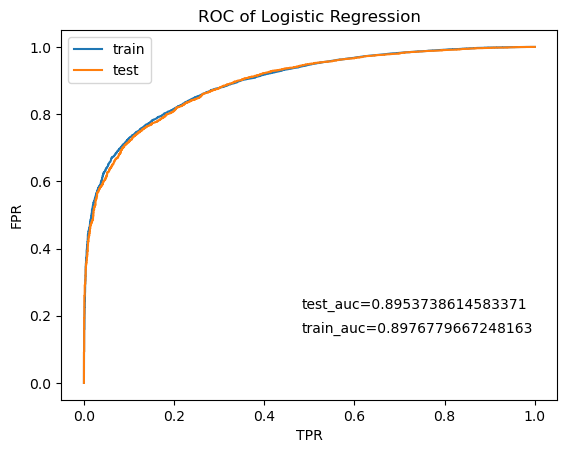

24/02/29 15:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1043.9 KiB
24/02/29 15:36:32 WARN DAGScheduler: Broadcasting large task binary with size 1494.4 KiB
24/02/29 15:36:36 WARN DAGScheduler: Broadcasting large task binary with size 1136.0 KiB
24/02/29 15:37:24 WARN DAGScheduler: Broadcasting large task binary with size 1041.1 KiB
24/02/29 15:37:34 WARN DAGScheduler: Broadcasting large task binary with size 1485.0 KiB
24/02/29 15:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1149.4 KiB
24/02/29 15:38:18 WARN DAGScheduler: Broadcasting large task binary with size 1039.9 KiB
24/02/29 15:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1491.3 KiB
24/02/29 15:38:33 WARN DAGScheduler: Broadcasting large task binary with size 1150.3 KiB
24/02/29 15:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1062.0 KiB


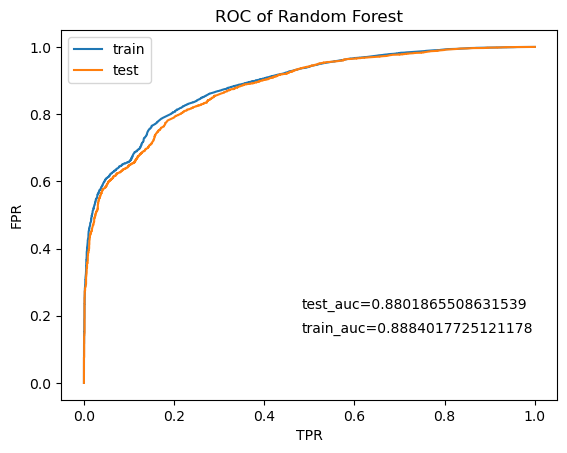

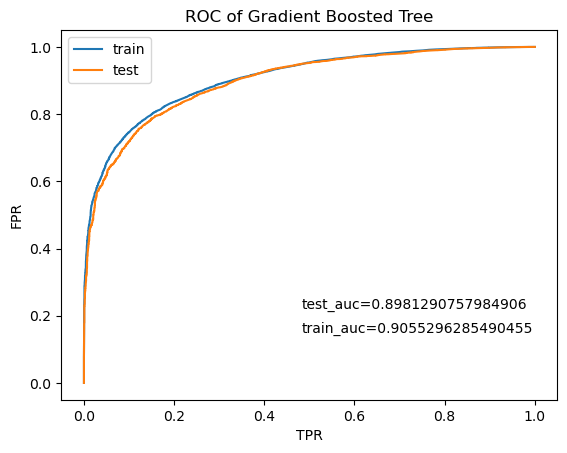

In [10]:
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

lr = LogisticRegression()
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.2, 0.1, 0.01]) \
    .build()
rf = RandomForestClassifier()
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [4,5,6]) \
    .addGrid(rf.numTrees, [50, 100, 150]) \
    .build()
gb = GBTClassifier()
paramGrid_gb = ParamGridBuilder() \
    .addGrid(gb.maxDepth, [4,5,6]) \
    .addGrid(gb.stepSize, [0.2, 0.1, 0.01]) \
    .build()

def train_clf(clf, clf_name, paramGrid, train, test):
    crossval = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=BinaryClassificationEvaluator(), numFolds=3)
    cvModel = crossval.fit(train)
    train_pred = cvModel.transform(train)
    test_pred = cvModel.transform(test)

    train_score = train_pred.select(vector_to_array("probability")[0]).collect()
    train_true = train_pred.select("label").collect()

    test_score = test_pred.select(vector_to_array("probability")[0]).collect()
    test_true = test_pred.select("label").collect()

    fpr, tpr, thresholds = roc_curve(train_true, train_score)
    train_roc_auc = auc(tpr, fpr)
    plt.plot(tpr,fpr)

    fpr, tpr, thresholds = roc_curve(test_true, test_score)
    test_roc_auc = auc(tpr, fpr)
    plt.plot(tpr,fpr)

    plt.xlabel("TPR")
    plt.ylabel("FPR")
    plt.title("ROC of " + clf_name)
    plt.figtext(0.5,0.25, "train_auc=" + str(train_roc_auc))
    plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
    plt.legend(["train", "test"])
    plt.show()
    return cvModel

lr_model = train_clf(lr, "Logistic Regression", paramGrid_lr, train, test)
rf_model = train_clf(rf, "Random Forest", paramGrid_rf, train, test)
gb_model = train_clf(gb, "Gradient Boosted Tree", paramGrid_gb, train, test)

In [227]:
import pandas as pd
import torch.utils.data as data_utils

df_train = train.toPandas()
df_train_X = df_train.features.map(list).apply(pd.Series)
df_train_X = (df_train_X - df_train_X.mean())/df_train_X.std()
df_train_y = pd.DataFrame(pd.concat((df_train.label, 1-df_train.label), axis=1))
trainset = data_utils.TensorDataset(torch.Tensor(df_train_X.values), torch.Tensor(df_train_y.values))
train_loader = data_utils.DataLoader(trainset, batch_size=50, shuffle=True)

df_test = test.toPandas()
df_test_X = df_test.features.map(list).apply(pd.Series)
df_test_X = (df_test_X - df_test_X.mean())/df_test_X.std()
df_test_y = pd.DataFrame(df_test.label)

In [242]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(38, 40)
        self.hidden2 = nn.Linear(40, 40)
        self.output = nn.Linear(40, 2)
        nn.init.normal_(self.hidden1.weight, mean=0, std=0.01)
        nn.init.normal_(self.hidden1.bias, mean=0, std=0.01)
        nn.init.normal_(self.hidden2.weight, mean=0, std=0.01)
        nn.init.normal_(self.hidden2.bias, mean=0, std=0.01)
        nn.init.normal_(self.output.weight, mean=0, std=0.01)
        nn.init.normal_(self.output.bias, mean=0, std=0.01)

    def forward(self, x):
        x = F.sigmoid(self.hidden1(x))
        x = F.sigmoid(self.hidden2(x))
        x = F.softmax(self.output(x), dim=1)
        return x

In [243]:
import torch.optim as optim

model = NeuralNetwork()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(50):

    running_loss = 0.0
    for i, d in enumerate(train_loader, 0):
        inputs, labels = d
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

[1,   200] loss: 0.566
[1,   400] loss: 0.539
[2,   200] loss: 0.534
[2,   400] loss: 0.519
[3,   200] loss: 0.507
[3,   400] loss: 0.493
[4,   200] loss: 0.486
[4,   400] loss: 0.478
[5,   200] loss: 0.472
[5,   400] loss: 0.470
[6,   200] loss: 0.469
[6,   400] loss: 0.467
[7,   200] loss: 0.469
[7,   400] loss: 0.463
[8,   200] loss: 0.463
[8,   400] loss: 0.465
[9,   200] loss: 0.467
[9,   400] loss: 0.462
[10,   200] loss: 0.462
[10,   400] loss: 0.465
[11,   200] loss: 0.465
[11,   400] loss: 0.463
[12,   200] loss: 0.459
[12,   400] loss: 0.467
[13,   200] loss: 0.461
[13,   400] loss: 0.466
[14,   200] loss: 0.461
[14,   400] loss: 0.463
[15,   200] loss: 0.463
[15,   400] loss: 0.461
[16,   200] loss: 0.462
[16,   400] loss: 0.459
[17,   200] loss: 0.460
[17,   400] loss: 0.463
[18,   200] loss: 0.461
[18,   400] loss: 0.462
[19,   200] loss: 0.461
[19,   400] loss: 0.459
[20,   200] loss: 0.465
[20,   400] loss: 0.458
[21,   200] loss: 0.461
[21,   400] loss: 0.457
[22,   200

In [244]:
y_pred = model(torch.Tensor(df_test_X.values)).squeeze().detach().numpy()

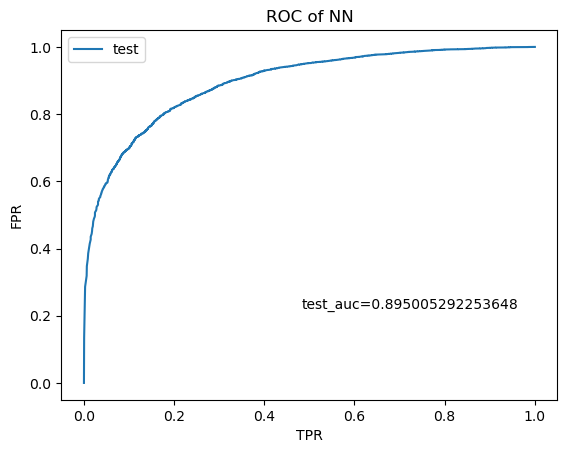

In [245]:
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred[:,1])
test_roc_auc = auc(tpr, fpr)
plt.plot(tpr,fpr)

plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC of NN")
plt.figtext(0.5,0.3, "test_auc=" + str(test_roc_auc))
plt.legend(["test"])
plt.show()

In [5]:
holdout_pred = lr_model.transform(holdout)
holdout_pred = holdout_pred.withColumn("score", vector_to_array(holdout_pred["probability"])[0])
holdout_pred_out = holdout_pred.select(["id","score"]).orderBy("score", ascending=False)

In [44]:
holdout_pred_out.write.options(header=True).csv('holdout.csv')